In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from datetime import timedelta
from dotenv import find_dotenv
from os.path import dirname
from os.path import exists
from os.path import join
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.load import load_train_df
from src.load import load_test_df
from src.transform import get_week_by_dept_df
from src.transform import unpivot_week_by_dept_df
from src.transform import svd_reconstruct
from src.features import make_id_column
from src.evaluate import wmae

# Root directory of repo
project_dir = dirname(find_dotenv())

# Use custom matplotlib style
plt.style.use(join(project_dir, 'big-darkgrid.mplstyle'))

In [3]:
d = get_week_by_dept_df()
d.head()

Store_Dept,10_1,10_10,10_11,10_12,10_13,10_14,10_16,10_17,10_18,10_19,...,9_9,9_90,9_91,9_92,9_93,9_94,9_95,9_96,9_97,9_98
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,40212.84,48027.87,36705.57,10365.86,74020.63,55033.94,25694.43,36872.18,8912.27,4046.34,...,7245.32,2335.92,292.64,11620.09,7.58,982.500000,23292.10,2438.08,668.48,1.5
2010-02-12,67699.32,50595.72,31052.34,9375.25,69145.42,51167.46,24555.89,34782.91,28176.35,3602.73,...,6556.94,2486.18,544.74,11080.50,7.58,982.500000,22317.38,2304.09,766.93,1.5
2010-02-19,49748.33,51199.72,33224.65,11032.90,68060.96,49011.24,33321.92,34512.54,16244.14,3617.85,...,7301.19,2452.70,424.26,10233.49,7.58,2163.750000,20694.32,1944.11,607.02,1.5
2010-02-26,33601.22,50028.83,29268.91,11058.90,71517.99,49829.71,27773.67,31175.51,916.25,4207.51,...,7814.18,2386.49,470.43,10786.42,7.58,2059.545455,21780.08,2423.55,580.74,1.5
2010-03-05,36572.44,49892.15,31934.99,11033.07,70279.43,46865.98,35227.56,33143.03,1426.47,3623.52,...,10540.89,2369.01,679.47,11176.21,7.58,1955.340909,22187.57,2591.28,371.05,1.5


Make sure the `svd_reconstruct` function works to reproduce the data with some dimensionality reduction:

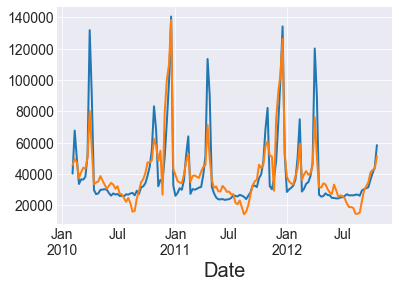

In [4]:
df2 = svd_reconstruct(d, n_comp=5)
fig, ax = plt.subplots()
d['10_1'].plot(ax=ax)
df2['10_1'].plot(ax=ax)
plt.show()

In [5]:
class ArimaModel():
    def __init__(self, fillna_method='interpolate', return_pivoted=False,
                 svd=True, n_comp=10):
        self.model_dict = {}
        self.fillna_method = fillna_method
        self.svd = svd
        self.return_pivoted = return_pivoted
        self.n_comp = n_comp

    def fit_predict(self, X_train, X_test):
        self.week_by_dept = get_week_by_dept_df(X_train)
        X_test = make_id_column(X_test)
        pred_week_by_dept = get_week_by_dept_df(X_test, fillna_method=None, values=None)
        if self.svd:
            self.week_by_dept = svd_reconstruct(self.week_by_dept,
                                                n_comp=self.n_comp)
        for c in pred_week_by_dept.columns:
            if c in self.week_by_dept.columns:
                ts = self.week_by_dept[c]
            else:
                ts = self.week_by_dept.mean(axis=1)
            import warnings
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = SARIMAX(
                    ts, trend='n', order=(0,1,0), seasonal_order=(0,1,0,52)
                ).fit(disp=0)
            start = len(self.week_by_dept)
            end = start + len(pred_week_by_dept)
            y_pred = model.predict(start=start, end=end, dynamic=True) 
            pred_week_by_dept[c] = y_pred

        if self.return_pivoted:
            return pred_week_by_dept
        else:
            unpivoted = unpivot_week_by_dept_df(pred_week_by_dept)
            unpivoted = make_id_column(unpivoted)
            unpivoted = unpivoted.set_index('Id', drop=True)
            unpivoted = unpivoted.reindex(X_test['Id'])
            return unpivoted['Weekly_Sales']

My ARIMA model is performing slowly, so I'll just train and predict Store 1.

In [6]:
full_train_df = load_train_df()
full_train_df = full_train_df[full_train_df['Store']==1]
split_date = full_train_df['Date'].min() + timedelta(weeks=104)
train_df = full_train_df[full_train_df['Date']<split_date]
test_df = full_train_df[full_train_df['Date']>=split_date]
test_df = make_id_column(test_df).set_index('Id', drop=True)
test_df, y_actual = test_df[['Store', 'Dept', 'Date', 'IsHoliday']], test_df['Weekly_Sales']

In [7]:
%%time
y_preds = []
for n_comp in [1, 5, 10, 50]:
    print("Doing n_comp =", n_comp)
    am = ArimaModel(svd=True, n_comp=n_comp)
    y_pred = am.fit_predict(train_df, test_df)
    y_preds.append(y_pred)

Doing n_comp = 1
Doing n_comp = 5
Doing n_comp = 10
Doing n_comp = 50
CPU times: user 3min 1s, sys: 7.78 s, total: 3min 9s
Wall time: 2min 57s


In [8]:
for n_comp, y_pred in zip([1,5,10,50], y_preds):
    print(
        "n_comp = {}, wmae = {}".format(
            n_comp,
            wmae(y_pred, y_actual, test_df['IsHoliday'])
        )
    )

n_comp = 1, wmae = 2997.160883056761
n_comp = 5, wmae = 2267.61042186421
n_comp = 10, wmae = 2136.399679292482
n_comp = 50, wmae = 2357.199968682306


Even though this was done on a subset of the data, we can see that there is an optimum number of components through which to reduce the data. That number might increase for when this is applied to all stores.